# Comparison of different normalization methods/features and impact on model

This are the questions I am trying to address with this notebook:
- which of the normalisation techniques provides meaningful information for clustering? look at inertia, number of
     clusters etc...
- which is the optimal dissimilarity metric for this task?
- visual inspection of normalised data;

In [41]:
from src.data.utils import normalize_col

import pandas as pd
import numpy as np
import glob


def make_labeled_nb(input_filepath, norm_type="integral"):
    file_list = glob.glob(input_filepath + '/*')
    for f in file_list:
        df = pd.read_csv(f, delim_whitespace=True, names=['wl', 'ri'])
        wl = df.wl
        data = df.drop(columns=['wl'])

        for col in data:
            df[f'{norm_type}_{col}'] = normalize_col(wl, data[col], norm_type=norm_type)

    return df

In [3]:
data_integral = make_labeled_nb("../data/raw/labeled", "integral")
data_zscore = make_labeled_nb("../data/raw/labeled", "zscore")

data_integral.head(), data_zscore.head()

(         wl        ri  integral_ri
 0  100.0000   0.00000     0.000000
 1  130.3772   0.00000     0.000000
 2  130.8593  29.94379     0.000018
 3  131.3414  40.09552     0.000025
 4  131.8235  32.20599     0.000020,
          wl        ri  zscore_ri
 0  100.0000   0.00000  -0.450377
 1  130.3772   0.00000  -0.450377
 2  130.8593  29.94379  -0.440640
 3  131.3414  40.09552  -0.437339
 4  131.8235  32.20599  -0.439904)

In [27]:
from scipy.stats import entropy


# I can add RMS, number of peaks, 0-crossings, ...
def stat_features(df, col_name):
    # First-order stats
    var = df[col_name].std()
    mean = df[col_name].mean()
    skew = df[col_name].skew()
    kurt = df[col_name].kurtosis()

    # Second-order stats
    signal_entropy = entropy(np.absolute(df[col_name]))

    return {
        "var": var,
        "mean": mean,
        "skew": skew,
        "kurt": kurt,
        "entropy": signal_entropy
    }

In [5]:
integral_feat = stat_features(data_integral, "integral_ri")
zscore_feat = stat_features(data_zscore, "zscore_ri")

integral_feat, zscore_feat

({'var': 0.001897976706764272,
  'mean': 0.0008546294407266169,
  'skew': 4.364274107468595,
  'kurt': 24.073100892495738,
  'entropy': 6.544725837429657},
 {'var': 1.000206079342734,
  'mean': -4.684253717413104e-17,
  'skew': 4.364274107468595,
  'kurt': 24.07310089249574,
  'entropy': 7.299249801563963})

var for zscore normalised is expected to be 1.

Extracting data with integral normalization
to compare with model:

In [24]:
from src.data.make_dataset import make_unlabeled, make_labeled

make_unlabeled("../data/raw/labeled", "../data/interim/labeled", "integral")
make_labeled("../data/raw/labeled", "../data/interim/labeled", "integral")

In [38]:
from src.features.utils import save_feat_files
from progress.bar import ShadyBar
import os


def extract_features(input_filepath: str, output_filepath: str) -> pd.DataFrame:
    """
    Builds features for clustering.
    """
    file_list = glob.glob(input_filepath + '/*')
    features_set = np.ndarray(shape=(len(file_list), 5))
    with ShadyBar(f"Extracting features {input_filepath}...", max=len(file_list)) as bar:
        for i, f in enumerate(file_list):
            interim_data = np.loadtxt(f, delimiter=',', skiprows=1)

            y_axis_data = interim_data[:, 1]

            features_set[i, :] = list(stat_features(pd.DataFrame({"data": y_axis_data}), col_name="data").values())

            bar.next()

    save_feat_files(features_set, os.path.join(output_filepath, "peaks_features.csv"))

In [40]:
extract_features("../data/interim/labeled", "../data/processed/labeled")
extract_features("../data/interim/unlabeled", "../data/processed/unlabeled")

Now training model on this features.

In [58]:
from src.models.train_model import train_model
import pickle

file_list = glob.glob('{0}/*'.format("../data/processed/labeled/"))

for f in file_list:
    with open(f, "rb") as f:
        data_x = pickle.load(f)

data_x = data_x.reshape(305, -1)

k_mean = train_model(data_x)

k_mean.inertia_

1598.046532880477

In [59]:
k_mean_inertia = []
for nc in range(3, 65):
    k_mean = train_model(data_x, n_clusters=nc)

    k_mean_inertia.append(k_mean.inertia_)

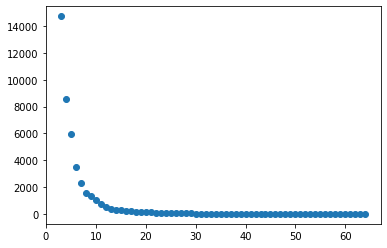

In [60]:
import matplotlib.pyplot as plt

plt.scatter(list(range(3, 65)), k_mean_inertia)

note that this feature set is not enough to cluster labeled samples. Thus I am not working on the right features.
(can't expect it to work on more noisy and unlabeled data).